## Import the necessary software libraries:

### Todos: 
are we training everything: try for 500-1000

check that every layer in 3 networks, we have non-zero gradient (just a few updates)

    - the gradient is non-zero, however, it is relatively small

check that the weight is changed after the update (just make sure the weight is changed for a few updates)

    - the weight does change a bit. However, for some reason, I cannot substract them and just print check if the result is 0

check that the actor action (histrogram of actor) check for a few episode

plot histrogram of the input, the state after preprocessing

change the hyper-parameter like lr, scale of the reward

### Todos:   500-1000 episodes
 use no frame skip version
 
 decrease a relative coefficient of entropy by factor of 10, 100
 
 change the hyper-parameter like lr 10 or .1, scale of the reward by 10 or .1
 
 try cv2 to resize the environment
 
 try having 2 frames, concaternate and give to the feature extractor, use copy method to save the previous frame

### Questions:

since we also have feature_optim don't we calculate loss and do backward propagation?



### Todos:

try stable baseline solution

try use new network

there might be issue at the preprocess step

In [2]:
import os
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn as nn
from torch.optim import AdamW
import torch.nn.functional as F

import torchvision.transforms as transforms
import json
import cv2

from utils import test_policy_network, seed_everything, plot_stats
from parallel_env import ParallelEnv, ParallelWrapper

import random

### import ROM from the extracted file to atari_py

In [ ]:
# run only once when creating conda environment
! python -m atari_py.import_roms /Users/meng/Downloads/Roms

In [ ]:
env_name = 'PongNoFrameskip-v4'
#env_name = 'Acrobot-v1'

env = gym.make(env_name)

input_space = env.observation_space.shape

actions = env.action_space.n

In [ ]:
print(f"State dimensions: {input_space}. Actions: {actions}")
print(f"Sample state: {env.reset()}")

In [ ]:
print(f"state_space[0] = {input_space[2]}")

In [ ]:
plt.imshow(np.real(env.render(mode='rgb_array')))

In [ ]:
class Environment:

    def __init__(self, env_name):
        self.env = gym.make(env_name)
        # seed_everything(self.env)

    def reset(self):
        obs = self.env.reset()
        return obs

    def step_async(self, actions):
        actions = actions.squeeze().numpy()
        self.env.step_async(actions)

    def step_wait(self):
        obs, reward, done, info = self.env.step_wait()
        obs = self.preprocess_observation(obs)
        reward = torch.tensor(reward).unsqueeze(1).float()
        done = torch.tensor(done).unsqueeze(1)
        return obs, reward, done, info

In [ ]:
class PreprocessEnv(ParallelWrapper):

    def __init__(self, env):
        super().__init__(env)

    def reset(self):
        state = self.venv.reset()
        return torch.from_numpy(state).float()

    def step_async(self, actions):
        actions = actions.squeeze().numpy()
        self.venv.step_async(actions)

    def step_wait(self):
        next_state, reward, done, info = self.venv.step_wait()
        next_state = torch.from_numpy(next_state).float()
        reward = torch.tensor(reward).unsqueeze(1).float()
        done = torch.tensor(done).unsqueeze(1)
        return next_state, reward, done, info

In [ ]:
class FeatureExtractor(nn.Module):

    def __init__(self, input_shape):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*4*4, 512)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = x.view(-1, 64*4*4)
        
        x = F.relu(self.fc1(x))
        return x
        

In [ ]:
class Actor(nn.Module):

    def __init__(self, n_actions):
        super().__init__()

        self.fc1 = nn.Linear(in_features=512, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=n_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x

In [ ]:
class Critic(nn.Module):

    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(in_features=512, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
class ActorCritic():
    def __init__(self, actor, critic, feature, num_envs, num_frames, alpha=1e-4, gamma=0.99):
        self.actor = actor
        self.critic = critic
        self.feature = feature
        self.alpha = alpha
        self.gamma = gamma
        self.actor_optim = AdamW(self.actor.parameters(), lr=alpha)
        self.critic_optim = AdamW(self.critic.parameters(), lr=alpha)
        self.feature_optim = AdamW(self.feature.parameters(), lr=alpha)
        self.stats = {'Actor Loss': [], 'Critic Loss': [], 'Returns': []}
        self.best_return = -9999
        self.path = path
        self.num_frames = num_frames
        self.stacked_frames = torch.zeros((num_envs, num_frames, 64, 64))

    
    def preprocess_observation(self, obs_batch):
        # Crop the score and border region
        obs_batch = obs_batch[:, 35:195, :, :]

        # Convert to grayscale
        obs_batch = torch.mean(obs_batch, dim=3, keepdim=True)
    
        # Resize to 64x64
        transform = transforms.Resize((64, 64))
        
        obs_batch = torch.stack([transform(obs.permute(2, 0, 1)) for obs in obs_batch])
        
        # Convert to float and rescale to range [0, 1]
        obs_batch = obs_batch / 255.0
        
        return obs_batch
    
    def save_model(self, path="/data/best_model.pth.tar"):
        torch.save({
                    'actor_state_dict': self.actor.state_dict(),
                    'critic_state_dict': self.critic.state_dict(),
                    'feature_state_dict': self.feature.state_dict(),
                    'actor_optim_state_dict': self.actor_optim.state_dict(),
                    'critic_optim_state_dict': self.critic_optim.state_dict(),
                    'feature_optim_state_dict': self.feature_optim.state_dict(),
                }, path)
        
    def plot_image(self, obs_batch):
        # Select the index of the image you want to plot
        index = 0

        # Get the image tensor
        image_tensor = obs_batch[index]

        # Convert the tensor to a numpy array and remove the channel dimension
        image = image_tensor.squeeze().numpy()

        # Plot the image
        plt.imshow(image, cmap='gray')
        plt.show()

    def create_frames_batch(self, env, state):
        for i in range(self.num_frames):
            self.stacked_frames[:, i, :, :] = state.squeeze(dim=1)

    def add_frame(self, state):
        # state = state.unsqueeze(1)
        self.stacked_frames = torch.cat((self.stacked_frames[:, 1:, :, :], state), dim=1)

    def train(self, env, episodes):
        
        actor_actions = []
        
        for episode in tqdm(range(1, episodes + 1)):
            state = env.reset()
            state = self.preprocess_observation(state)
            
            done_b = torch.zeros((env.num_envs, 1), dtype=torch.bool)
            ep_return = torch.zeros((env.num_envs, 1))
            I = 1.
        
            self.create_frames_batch(env, state)

            i = 0
            
            while not done_b.all():
                
                self.critic_optim.zero_grad()
                self.actor_optim.zero_grad()

                featured = self.feature(self.stacked_frames)
                action_probs = self.actor(featured)
                
                action = torch.multinomial(action_probs, 1).squeeze().detach()
                

                next_state, reward, done, _ = env.step(action)
                next_state = self.preprocess_observation(next_state)
                self.add_frame(next_state)
                
                
                value = self.critic(featured)
                
                next_featured = self.feature(self.stacked_frames)
                
                target = reward + ~done * self.gamma * self.critic(next_featured).detach()
                critic_loss = F.mse_loss(value, target)
                
                
                advantage = (target - value).detach()
                #probs = self.actor(state)
                log_probs = torch.log(action_probs + 1e-6)
                
                action = action.view(-1, 1)
                
                action_log_prob = log_probs.gather(1, action)
                entropy = - torch.sum(action_probs * log_probs, dim=-1, keepdim=True)
                actor_loss = - I * action_log_prob * advantage - 0.01 * entropy
                actor_loss = actor_loss.mean()

                
                
                total_loss = actor_loss + critic_loss
                
                total_loss.backward()

                self.feature_optim.step()
                self.critic_optim.step()
                self.actor_optim.step()


                ep_return += reward
                done_b |= done
                state = next_state
                I = I * self.gamma
                
                
                self.plot_image(self.stacked_frames[:,1,:,:])

            
            current_return = ep_return.mean().item()
            if self.best_return < current_return:
                best_return = current_return
                self.save_model()
            
            
            self.stats['Actor Loss'].append(actor_loss.item())
            self.stats['Critic Loss'].append(critic_loss.item())
            self.stats['Returns'].append(ep_return.mean().item())
            
        # print(actor_actions)

## Main

In [ ]:
env_name = 'PongNoFrameskip-v4'
num_envs = os.cpu_count()
num_frames = 4
episodes = 1

In [ ]:
envs = ParallelEnv([lambda: gym.make(env_name) for _ in range(num_envs)])
envs = PreprocessEnv(envs)

In [ ]:
feature = FeatureExtractor(envs.observation_space.shape)
actor = Actor(envs.action_space.n)
critic = Critic()
agent = ActorCritic(actor, critic, feature, num_envs, num_frames)

In [ ]:
agent.train(envs, episodes)

In [ ]:
plot_stats(agent.stats)

## End_main

In [7]:
# plotting a histogram of a decision

with open('/Users/meng/Documents/semester8/Thesis/workspace/pong_and_a2c/data/data11_4frames_lr7e-4_entropy0.01/meng/actor_actions.txt', 'r') as f:
    # Load the contents of the file as a JSON object
    actions = json.load(f)

# plot histogram
plt.hist(actions, bins=range(3))
plt.xlabel('Action')
plt.ylabel('Count')
plt.xticks(range(6))
plt.show()






JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
# plotting an input states

with open('/Users/meng/Documents/semester8/Thesis/workspace/pong_and_a2c/data10/meng/meng/input_states.txt', 'r') as f:
    # Load the contents of the file as a JSON object
    hist_data = json.load(f)
    
#hist_data = input_states.numpy()

# Plot the histogram
plt.hist(hist_data, bins=50)
plt.show()
    

In [ ]:
print(hist_data.shape)

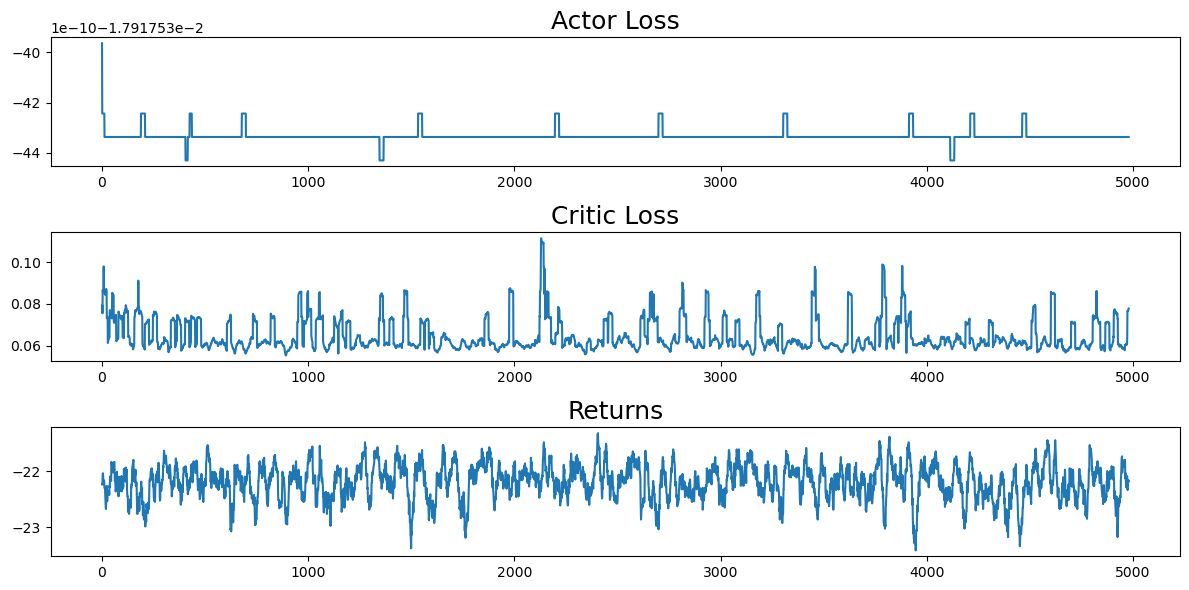

In [3]:
with open('/Users/meng/Documents/semester8/Thesis/workspace/pong_and_a2c/data/data14_lr7e-4_entropy0.01/meng/stats.txt', 'r') as f:
    # Load the contents of the file as a JSON object
    stats_loaded = json.load(f)
plot_stats(stats_loaded)

In [ ]:
# check the name of weight parameter of the network

for name, param in agent.actor.state_dict().items():
    print(name)

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch

env = gym.make('Pong-v0')

# Define the preprocessing function
def preprocess_state(state):
    # Convert the image to grayscale
    # state = np.dot(state[..., :3], [0.299, 0.587, 0.114])
    
    # Crop the image to remove irrelevant parts
    state = state[34:194, :]
    
    # Rescale the image to a smaller size
    state = state[::2, ::2]
    
    # Normalize the pixel values
    state = state / 255.0
    
    # Convert the state to a PyTorch tensor
    state = torch.from_numpy(state).float().unsqueeze(0).unsqueeze(0)
    
    return state

# Get a batch of preprocessed states
states = []
for i in range(3):
    state = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()
        next_state, _, done, _ = env.step(action)
        state = preprocess_state(next_state)
        states.append(state)

# Convert the list of states to a single tensor
states = torch.cat(states)

# Flatten the tensor and convert it to a NumPy array
hist_data = states.flatten().numpy()

# Plot the histogram
plt.hist(hist_data, bins=50)
plt.show()

In [ ]:
                
                   '''
                # Check gradients
                for name, param in self.feature.named_parameters():
                    if param.grad is not None:
                        print(f"feature.{name} gradient: {param.grad.norm()}")
                for name, param in self.actor.named_parameters():
                    if param.grad is not None:
                        print(f"actor.{name} gradient: {param.grad.norm()}")
                for name, param in self.critic.named_parameters():
                    if param.grad is not None:
                        print(f"critic.{name} gradient: {param.grad.norm()}")
                '''
    '''
                # Before optimizer step
                old_weights_feature_conv1 = self.feature.state_dict()['conv1.weight']
                old_weights_feature_conv2 = self.feature.state_dict()['conv2.weight']
                old_weights_feature_conv3 = self.feature.state_dict()['conv3.weight']
                old_weights_feature_conv4 = self.feature.state_dict()['conv4.weight']
                old_weights_feature_fc1 = self.feature.state_dict()['fc1.weight']
                
                old_weights_actor_fc1 = self.actor.state_dict()['fc1.weight']
                old_weights_actor_fc2 = self.actor.state_dict()['fc2.weight']
                
                old_weights_critic_fc1 = self.critic.state_dict()['fc1.weight']
                old_weights_critic_fc2 = self.critic.state_dict()['fc2.weight']
                '''
                
                '''
                # Print the weight
                if i==0:
                    print(f"old_weight_feature_conv1: {self.feature.state_dict()['conv1.weight']}")
                    print(f"old_weight_feature_conv2: {self.feature.state_dict()['conv1.weight']}")
                    print(f"old_weight_feature_conv3: {self.feature.state_dict()['conv1.weight']}")
                    print(f"old_weight_feature_conv4: {self.feature.state_dict()['conv1.weight']}")
                    print(f"old_weight_feature_conv5: {self.feature.state_dict()['conv1.weight']}")
                    
                    print(f"old_weights_actor_fc1: {self.actor.state_dict()['fc1.weight']}")
                    print(f"old_weights_actor_fc2: {self.actor.state_dict()['fc2.weight']}")
                    
                    print(f"old_weights_critic_fc1: {self.critic.state_dict()['fc1.weight']}")
                    print(f"old_weights_critic_fc2: {self.critic.state_dict()['fc2.weight']}")
                '''
                            '''
                if i==0:
                    print(f"new_weight_feature_conv1: {self.feature.state_dict()['conv1.weight']}")
                    print(f"new_weight_feature_conv2: {self.feature.state_dict()['conv1.weight']}")
                    print(f"new_weight_feature_conv3: {self.feature.state_dict()['conv1.weight']}")
                    print(f"new_weight_feature_conv4: {self.feature.state_dict()['conv1.weight']}")
                    print(f"new_weight_feature_conv5: {self.feature.state_dict()['conv1.weight']}")
                    
                    print(f"new_weights_actor_fc1: {self.actor.state_dict()['fc1.weight']}")
                    print(f"new_weights_actor_fc2: {self.actor.state_dict()['fc2.weight']}")
                    
                    print(f"new_weights_critic_fc1: {self.critic.state_dict()['fc1.weight']}")
                    print(f"new_weights_critic_fc2: {self.critic.state_dict()['fc2.weight']}")
                    
                    i = 1

                '''
                
                                '''
                # After optimizer step
                
                new_weights_feature_conv1 = self.feature.state_dict()['conv1.weight']
                new_weights_feature_conv2 = self.feature.state_dict()['conv2.weight']
                new_weights_feature_conv3 = self.feature.state_dict()['conv3.weight']
                new_weights_feature_conv4 = self.feature.state_dict()['conv4.weight']
                new_weights_feature_fc1 = self.feature.state_dict()['fc1.weight']
                
                new_weights_actor_fc1 = self.actor.state_dict()['fc1.weight']
                new_weights_actor_fc2 = self.actor.state_dict()['fc2.weight']
                
                new_weights_critic_fc1 = self.critic.state_dict()['fc1.weight']
                new_weights_critic_fc2 = self.critic.state_dict()['fc2.weight']
                
                
                
                
                # Check if weights have changed
                if torch.equal(old_weights_feature_conv1, new_weights_feature_conv1):
                    print("Feature conv1 weights have not changed!")
                if torch.equal(old_weights_feature_conv2, new_weights_feature_conv2):
                    print("Feature conv2 weights have not changed!")
                if torch.equal(old_weights_feature_conv3, new_weights_feature_conv3):
                    print("Feature conv3 weights have not changed!")  
                if torch.equal(old_weights_feature_conv4, new_weights_feature_conv4):
                    print("Feature conv4 weights have not changed!")
                if torch.equal(old_weights_feature_fc1, new_weights_feature_fc1):
                    print("Feature fc1 weights have not changed!")
                    
                if torch.equal(old_weights_actor_fc1, new_weights_actor_fc1):
                    print("Actor fc1 weights have not changed!")
                if torch.equal(old_weights_actor_fc2, new_weights_actor_fc2):
                    print("Actor fc2 weights have not changed!")
                    
                if torch.equal(old_weights_critic_fc1, new_weights_critic_fc1):
                    print("Critic fc1 weights have not changed!")
                if torch.equal(old_weights_critic_fc2, new_weights_critic_fc2):
                    print("Critic fc2 weights have not changed!")

                '''

In [ ]:
# Define your loss function and optimizer
loss_fn = ...
optimizer = ...

# Inside your training loop
for episode in range(num_episodes):
    # Forward pass
    features = feature_extractor(state)
    action_probs = actor(features)
    value_estimate = critic(features)

    # Compute loss and gradients
    loss = compute_loss(...)
    optimizer.zero_grad()
    loss.backward()

    # Check gradients
    for name, param in feature_extractor.named_parameters():
        if param.grad is not None:
            print(f"{name} gradient: {param.grad.norm()}")
    for name, param in actor.named_parameters():
        if param.grad is not None:
            print(f"{name} gradient: {param.grad.norm()}")
    for name, param in critic.named_parameters():
        if param.grad is not None:
            print(f"{name} gradient: {param.grad.norm()}")

    # Update parameters
    optimizer.step()

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Create an environment
env = gym.make('Pong-v0')

# Reset the environment and get the initial observation
observation = env.reset()

# Preprocess the observation by cutting and resizing to 64x64
observation = observation[35:195, :, :]
observation = np.mean(observation, axis=2)
observation = observation[::2, ::2]


#observation = np.reshape(observation, (64, 64))
observation = cv2.resize(observation, (64, 64))

print('Observation shape:', observation.shape)

# Plot the preprocessed observation
plt.imshow(observation)
plt.show()

In [ ]:
import gym

env = gym.make('Pong-v4', skip=0)

# start the game and reset the environment
observation = env.reset()

# play the game with no frame skipping
while True:
    # take random actions
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    
    # check if the game is over
    if done:
        break

env.close()

In [ ]:
# Checking if the ball is visible when scale down to 64x64

import gym
import random
import matplotlib.pyplot as plt
import numpy as np

import cv2

# code for the two only actions in Pong
UP_ACTION = 2
DOWN_ACTION = 3

# initializing our environment
env = gym.make('Pong-v4', frameskip=20)

# beginning of an episode
observation = env.reset()



# main loop
for i in range(3):
    

    # choose random action
    action = random.randint(UP_ACTION, DOWN_ACTION) 

    # run one step
    observation, reward, done, info = env.step(action)
    
    # Preprocess the observation by cutting and resizing to 64x64
    #observation = observation[35:195, :, :]
    #observation = np.mean(observation, axis=2)
    #observation = observation[::2, ::2]


    #observation = np.reshape(observation, (64, 64))
    #observation = cv2.resize(observation, (64, 64))
    
    

# Plot the preprocessed observation

print('Observation shape:', observation.shape)
plt.imshow(observation)
plt.show()
    

    # if the episode is over, reset the environment
    # if done:
    #    env.reset()
        

In [ ]:
import gym
import random
import matplotlib.pyplot as plt
import torch
import cv2

UP_ACTION = 2
DOWN_ACTION = 3

# Create the environment
env = gym.make("Pong-v0)

# Reset the environment and get the initial observation
observation = env.reset()

for i in range(20):
    # Choose a random action
    action = random.randint(UP_ACTION, DOWN_ACTION)

    # Take a step in the environment
    observation, reward, done, info = env.step(action)

    # Preprocess the observation
    observation = observation[35:195, :, :]
    observation = torch.mean(torch.Tensor(observation), dim=2)
    observation = observation[::2, ::2]
    observation = cv2.resize(observation.numpy(), (64, 64))
    
print('Observation shape:', observation.shape)
plt.imshow(observation, cmap='gray')
plt.show()

In [ ]:
env = gym.make(env_name)
test_policy_network_internal(env, agent.actor, agent.feature_extractor, episodes=2)

In [ ]:
def test_policy_network_internal(env, policy, feature_extractor, episodes=1):
    from IPython import display
    plt.figure(figsize=(6, 6))
    for episode in range(episodes):
        state = env.reset()
        state = preprocess(state)
        state = agent.feature_extractor(state)
        done = False
        img = plt.imshow(env.render(mode='rgb_array'))
        while not done:
            # state = torch.from_numpy(state).unsqueeze(0).float()
            action = policy(state).multinomial(1).item()
            next_state, _, done, _ = env.step(action)
            img.set_data(env.render(mode='rgb_array'))
            plt.axis('off')
            display.display(plt.gcf())
            display.clear_output(wait=True)
            state = next_state

In [ ]:
def preprocess(obs):
        # Convert to float and rescale to range [0, 1]
        #obs_batch = obs_batch.astype(np.float32) / 255.0
        
        obs = torch.from_numpy(obs)
    
        # Crop the score and border region
        obs = obs[35:195, :, :]
    
        # Resize to 64x64
        transform = transforms.Resize((64, 64))
        obs = transform(obs.permute(2, 0, 1))
        obs = obs.float()
    
        return obs

## for testing

In [ ]:
import os
from utils import test_policy_network, seed_everything, plot_stats
from parallel_env import ParallelEnv, ParallelWrapper

def preprocess_observation(obs_batch):
        # Crop the score and border region
        obs_batch = obs_batch[:, 35:195, :, :]
    
        # Resize to 64x64
        transform = transforms.Resize((64, 64))
        
        obs_batch = torch.stack([transform(obs.permute(2, 0, 1)) for obs in obs_batch])
        
        # Convert to float and rescale to range [0, 1]
        obs_batch = obs_batch / 255.0
        
        return obs_batch
    

env_name = 'Pong-v4'
num_envs = os.cpu_count()
episodes = 10

envs = ParallelEnv([lambda: Environment(env_name).env for _ in range(num_envs)])
envs = PreprocessEnv(envs)

print(envs)

In [ ]:
env = gym.make('Pong-v0')
env.unwrapped.ball_size = 5  # Set the ball size to 5 pixels
env.unwrapped.ball_color = (255, 255, 255)  # Set the ball color to white
env.reset()

# Play one step of the game to get an image with the ball
obs, _, _, _ = env.step(0)

# Render the environment
img = env.render(mode='rgb_array')
# img = env.render(mode='rgb_array', viewer='pyglet')


# Display the image
plt.imshow(img)
plt.show()

In [ ]:
feature = feature_extractor(state)

In [ ]:
probs = actor(feature)

In [ ]:
print(probs.shape)

In [ ]:
def plot_state(env, policy, episodes=1):
    from IPython import display
    plt.figure(figsize=(6, 6))
    for episode in range(episodes):
        state = env.reset()
        done = False
        img = plt.imshow(env.render(mode='rgb_array'))
        while not done:
            state = torch.from_numpy(state).unsqueeze(0).float()
            action = policy(state).multinomial(1).item()
            next_state, _, done, _ = env.step(action)
            img.set_data(env.render(mode='rgb_array'))
            plt.axis('off')
            display.display(plt.gcf())
            display.clear_output(wait=True)
            state = next_state

In [ ]:
def test_policy_network(env, policy, episodes=1):
    from IPython import display
    plt.figure(figsize=(6, 6))
    for episode in range(episodes):
        state = env.reset()
        done = False
        img = plt.imshow(env.render(mode='rgb_array'))
        while not done:
            state = torch.from_numpy(state).unsqueeze(0).float()
            action = policy(state).multinomial(1).item()
            next_state, _, done, _ = env.step(action)
            img.set_data(env.render(mode='rgb_array'))
            plt.axis('off')
            display.display(plt.gcf())
            display.clear_output(wait=True)
            state = next_state

In [ ]:
def preprocess_observation(obs_batch):
    # selecting the row from 35 to 195 so that we have a space of 160 * 160
    obs_batch = obs_batch[:, 35:195, :, :]
    # change to gray scale
    obs_batch = np.dot(obs_batch, [0.2989, 0.5870, 0.1140])
    # resize 
    obs_batch = np.transpose(obs_batch, (1, 2, 0))
    obs_batch = cv2.resize(obs_batch, (64, 64), interpolation=cv2.INTER_AREA)
    #obs_batch = obs_batch.astype(np.float32) / 255.0
    #obs_batch = torch.from_numpy(obs_batch).unsqueeze(1)
    return obs_batch

In [ ]:
def preprocess_observation(obs_batch):
    obs_batch = obs_batch[:, 35:195, :, :]
    obs_batch = cv2.resize(obs_batch, (64, 64), interpolation=cv2.INTER_AREA)
    #obs_batch = obs_batch.astype(np.float32) / 255.0
    #obs_batch = torch.from_numpy(obs_batch).permute(0, 3, 1, 2)
    return obs_batch

In [ ]:
def resize_observation(obs_batch):
    # create an empty array to hold the resized observations
    resized_obs = np.empty((obs_batch.shape[0], 1, 64, 64), dtype=np.float32)

    for i, obs in enumerate(obs_batch):
        # selecting the row from 35 to 195 so that we have a space of 160 * 160
        obs = obs[35:195, :, :]
        # resize
        obs = cv2.resize(obs, (64, 64), interpolation=cv2.INTER_AREA)
        # convert to float32 and normalize
        obs = obs.astype(np.float32) / 255.0
        # transpose from (64, 64, 3) to (3, 64, 64) and add an extra dimension
        obs = np.transpose(obs, (2, 0, 1))[np.newaxis, ...]
        # add to the resized observations array
        resized_obs[i] = obs

    return resized_obs

In [ ]:
def preprocess_observation(obs_batch):
    # selecting the row from 35 to 195 so that we have a space of 160 * 160
    obs_batch = obs_batch[:, 35:195, :, :]
    # resize 
    obs_batch = np.transpose(obs_batch, (0, 3, 1, 2))
    obs_batch = np.asarray([cv2.resize(img, (64, 64), interpolation=cv2.INTER_AREA) for img in obs_batch])
    obs_batch = obs_batch.astype(np.float32) / 255.0
    obs_batch = torch.from_numpy(obs_batch).unsqueeze(1)
    return obs_batch

In [ ]:
def preprocess_observation(obs_batch):
    # Convert to float and rescale to range [0, 1]
    #obs_batch = obs_batch.astype(np.float32) / 255.0
    
    # Crop the score and border region
    obs_batch = obs_batch[:, 35:195, :, :]
    
    # Resize to 64x64
    transform = transforms.Resize((64, 64))
    obs_batch = torch.stack([transform(obs.permute(2, 0, 1)) for obs in obs_batch])
    
    return obs_batch


In [ ]:
def preprocess_observation(obs_batch):
    # Crop the score and border region
    obs_batch = obs_batch[:, 35:195, :, :]

    # Resize to 64x64
    resized_obs_batch = []
    for obs in obs_batch:
        resized_obs = cv2.resize(obs.permute(1, 2, 0).numpy(), (64, 64))
        resized_obs_batch.append(torch.tensor(resized_obs).permute(2, 0, 1))

    # Stack into a batch
    obs_batch = torch.stack(resized_obs_batch)

    # Convert to float and rescale to range [0, 1]
    obs_batch = obs_batch.float() / 255.0

    return obs_batch

In [ ]:
def preprocess_observation(obs_batch):
    # Crop the score and border region
    obs_batch = obs_batch[:, 35:195, :, :]

    # Resize to 160x160
    obs_batch = np.array([cv2.resize(obs, (64, 64)) for obs in obs_batch])
        
    # Convert to grayscale
    obs_batch = np.array([cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY) for obs in obs_batch])

    # Convert to float and rescale to range [0, 1]
    obs_batch = obs_batch / 255.0

    # Add channel dimension to match PyTorch convention
    obs_batch = np.expand_dims(obs_batch, axis=1)

    # Convert to PyTorch tensor
    obs_batch = torch.from_numpy(obs_batch).float()


    
    return obs_batch

In [ ]:
def preprocess_observation(obs_batch):
    obs_batch = obs_batch[:, 35:195, :, :]  # Crop the score and border region
    obs_batch = obs_batch.numpy()  # Convert to NumPy array
    obs_batch = np.array([cv2.resize(obs, (64, 64)) for obs in obs_batch])  # Resize to 64x64
    obs_batch = np.array([cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY) for obs in obs_batch])  # Convert to grayscale
    obs_batch = obs_batch.astype(np.float32) / 255.0  # Normalize to [0, 1] range
    return obs_batch

In [ ]:
def preprocess_observation(obs_batch):
    # Crop the score and border region
    obs_batch = obs_batch[:, 35:195, :, :]
    
    # Resize to 64x64
    transform = transforms.Resize((64, 64))
    
    # Convert to grayscale
    obs_batch = torch.stack([torch.tensor(cv2.cvtColor(obs.permute(2, 0, 1).numpy(), cv2.COLOR_RGB2GRAY)) for obs in obs_batch])
    obs_batch = obs_batch.unsqueeze(1)
    
    # Convert to float and rescale to range [0, 1]
    obs_batch = obs_batch.float() / 255.0
    
    return obs_batch

In [ ]:
obs_shape=(1, 64, 64)

In [ ]:
env_name = 'Pong-v4'
env = gym.make(env_name)

In [ ]:
env = Environment(env_name)
obs = env.reset()
print(obs.shape)

In [ ]:
obs = envs.reset()
print(obs.shape)

In [ ]:
print(state.shape)

In [ ]:
UP_ACTION = 2
DOWN_ACTION = 3

env_name = 'Pong-v4'
num_envs = 8

env = gym.make(env_name)

envs = ParallelEnv([lambda: env for _ in range(num_envs)])
envs = PreprocessEnv(envs)

In [ ]:
state = envs.reset()
state = preprocess_observation(state)
for i in range(20):
    
    action = random.randint(UP_ACTION, DOWN_ACTION) 
    
    next_state, reward, done, _ = envs.step(action)
    next_state = preprocess_observation(next_state)
    
print('Observation shape:', observation.shape)
env = state[0]

print(env.shape)
# Plot the image using matplotlib
plt.imshow(env.squeeze(), cmap='gray')
plt.show()

In [ ]:
print(obs.shape)

In [ ]:
state = preprocess_observation(envs)

In [ ]:
state = resize_observation(obs)

## Just in case

In [ ]:

    #def plot_stats(self):
    #    plt.plot(self.stats['Actor Loss'], label='Actor Loss')
    #    plt.plot(self.stats['Critic Loss'], label='Critic Loss')
    #    plt.plot(self.stats['Returns'], label='Returns')
    #    plt.legend()
    #    plt.show()

    #def test_policy_network(self, env, episodes=2):
    #    with torch.no_grad():
    #        for episode in range(episodes):
    #            state = env.reset()
    #            done = False
    #            total_reward = 0

    #            while not done:
    #                action = self.actor(state).argmax(dim=1).detach()
    #                next_state, reward, done, _ = env.step(action)
    #                total_reward += reward
    #                state = next_state

    #            print(f'Episode {episode+1}: Total reward = {total_reward.item()}')
